In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import cv2
from sklearn.model_selection import train_test_split
import random



2025-06-08 20:19:04.581302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:

# Pixel RGB codes
FOREST_RGB = [57, 125, 73]

# ------------ Data Generator ------------ #
class EncroachmentDataGenerator(Sequence):
    def __init__(self, image_dir_2018, image_dir_2023, mask_dir, batch_size=8, image_size=(256, 256), shuffle=True):
        self.image_dir_2018 = image_dir_2018
        self.image_dir_2023 = image_dir_2023
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_ids = sorted(os.listdir(image_dir_2018))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for img_id in batch_ids:
            # Load 2018 & 2023 images
            path_2018 = os.path.join(self.image_dir_2018, img_id)
            path_2023 = os.path.join(self.image_dir_2023, img_id)
            image_2018 = cv2.imread(path_2018)[:, :, ::-1]  # BGR to RGB
            image_2023 = cv2.imread(path_2023)[:, :, ::-1]

            # Resize
            image_2018 = cv2.resize(image_2018, self.image_size)
            image_2023 = cv2.resize(image_2023, self.image_size)

            # Normalize to [0,1]
            image_2018 = image_2018 / 255.0
            image_2023 = image_2023 / 255.0

            # Forest masks
            forest_mask_2018 = self.get_forest_mask(image_2018)
            forest_mask_2023 = self.get_forest_mask(image_2023)

            # Stack inputs -> 8 channels
            combined = np.concatenate([
                image_2018, image_2023,
                forest_mask_2018[..., np.newaxis],
                forest_mask_2023[..., np.newaxis]
            ], axis=-1)

            # Load mask
            mask_path = os.path.join(self.mask_dir, img_id)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.image_size)
            mask = (mask > 127).astype(np.float32)  # binarize

            X.append(combined)
            y.append(mask[..., np.newaxis])

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def get_forest_mask(self, img):
        # img is normalized to [0,1]
        forest_rgb = np.array(FOREST_RGB) / 255.0
        return np.all(np.abs(img - forest_rgb) < 0.05, axis=-1).astype(np.uint8)


In [11]:
# ------------ U-Net Model ------------ #
def build_unet(input_shape=(256, 256, 8)):
    inputs = tf.keras.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)

    return models.Model(inputs, outputs)




In [4]:
# ------------ Compile & Train ------------ #
image_dir_2018 = '/Users/admin/Downloads/Junagadh_2018_tif'
image_dir_2023 = '/Users/admin/Downloads/Junagadh_2023_tif'
mask_dir = '/Users/admin/Downloads/Junagadh_Mask_tif'

train_gen = EncroachmentDataGenerator(image_dir_2018, image_dir_2023, mask_dir)

#model = build_unet()
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model.fit(train_gen, epochs=25)

In [5]:
#model.save('forest_encroachment.keras')  # Save model to file
model = tf.keras.models.load_model('/Users/admin/Work/forest_encroachment.keras')


In [6]:
def visualize_single_prediction(model, generator, pixel_area_m2, index=None):
    # Choose random index if not provided
    if index is None:
        index = random.randint(0, len(generator) - 1)

    # Get batch from generator
    X_batch, y_batch = generator[index]
    preds = model.predict(X_batch)
    
    # Use first image in the batch
    input_stack = X_batch[0]
    true_mask = y_batch[0].squeeze()
    pred_mask = preds[0].squeeze()

    # Extract image pairs and forest masks
    img_2018 = input_stack[:, :, 0:3]
    img_2023 = input_stack[:, :, 3:6]
    forest_mask_2018 = input_stack[:, :, 6]
    forest_mask_2023 = input_stack[:, :, 7]

    # Convert prediction to binary
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    # Compute prediction error
    error_mask = (pred_mask_bin != true_mask).astype(np.uint8)

    # --- Calculate encroached area ---
    def calculate_area(mask, pixel_area_m2):
        return np.sum(mask) * pixel_area_m2 / 10_000  # hectares

    area_ha = calculate_area(pred_mask_bin, pixel_area_m2)

    # --- Plot ---
    fig, axs = plt.subplots(2, 4, figsize=(22, 10))

    axs[0, 0].imshow(img_2018)
    axs[0, 0].set_title("Image 2018")

    axs[0, 1].imshow(img_2023)
    axs[0, 1].set_title("Image 2023")

    axs[0, 2].imshow(forest_mask_2018, cmap='Greens')
    axs[0, 2].set_title("Forest Mask 2018")

    axs[0, 3].imshow(forest_mask_2023, cmap='Greens')
    axs[0, 3].set_title("Forest Mask 2023")

    axs[1, 0].imshow(true_mask, cmap='gray')
    axs[1, 0].set_title("Ground Truth Mask")

    axs[1, 1].imshow(pred_mask_bin, cmap='gray')
    axs[1, 1].set_title("Predicted Mask (Binary)")

    axs[1, 2].imshow(error_mask, cmap='Reds')
    axs[1, 2].set_title("Prediction Error")

    axs[1, 3].text(0.1, 0.5, f"Estimated Encroached Area:\n{area_ha:.2f} hectares",
                  fontsize=14, verticalalignment='center', transform=axs[1, 3].transAxes)
    axs[1, 3].set_title("Encroached Area")
    axs[1, 3].axis('off')

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


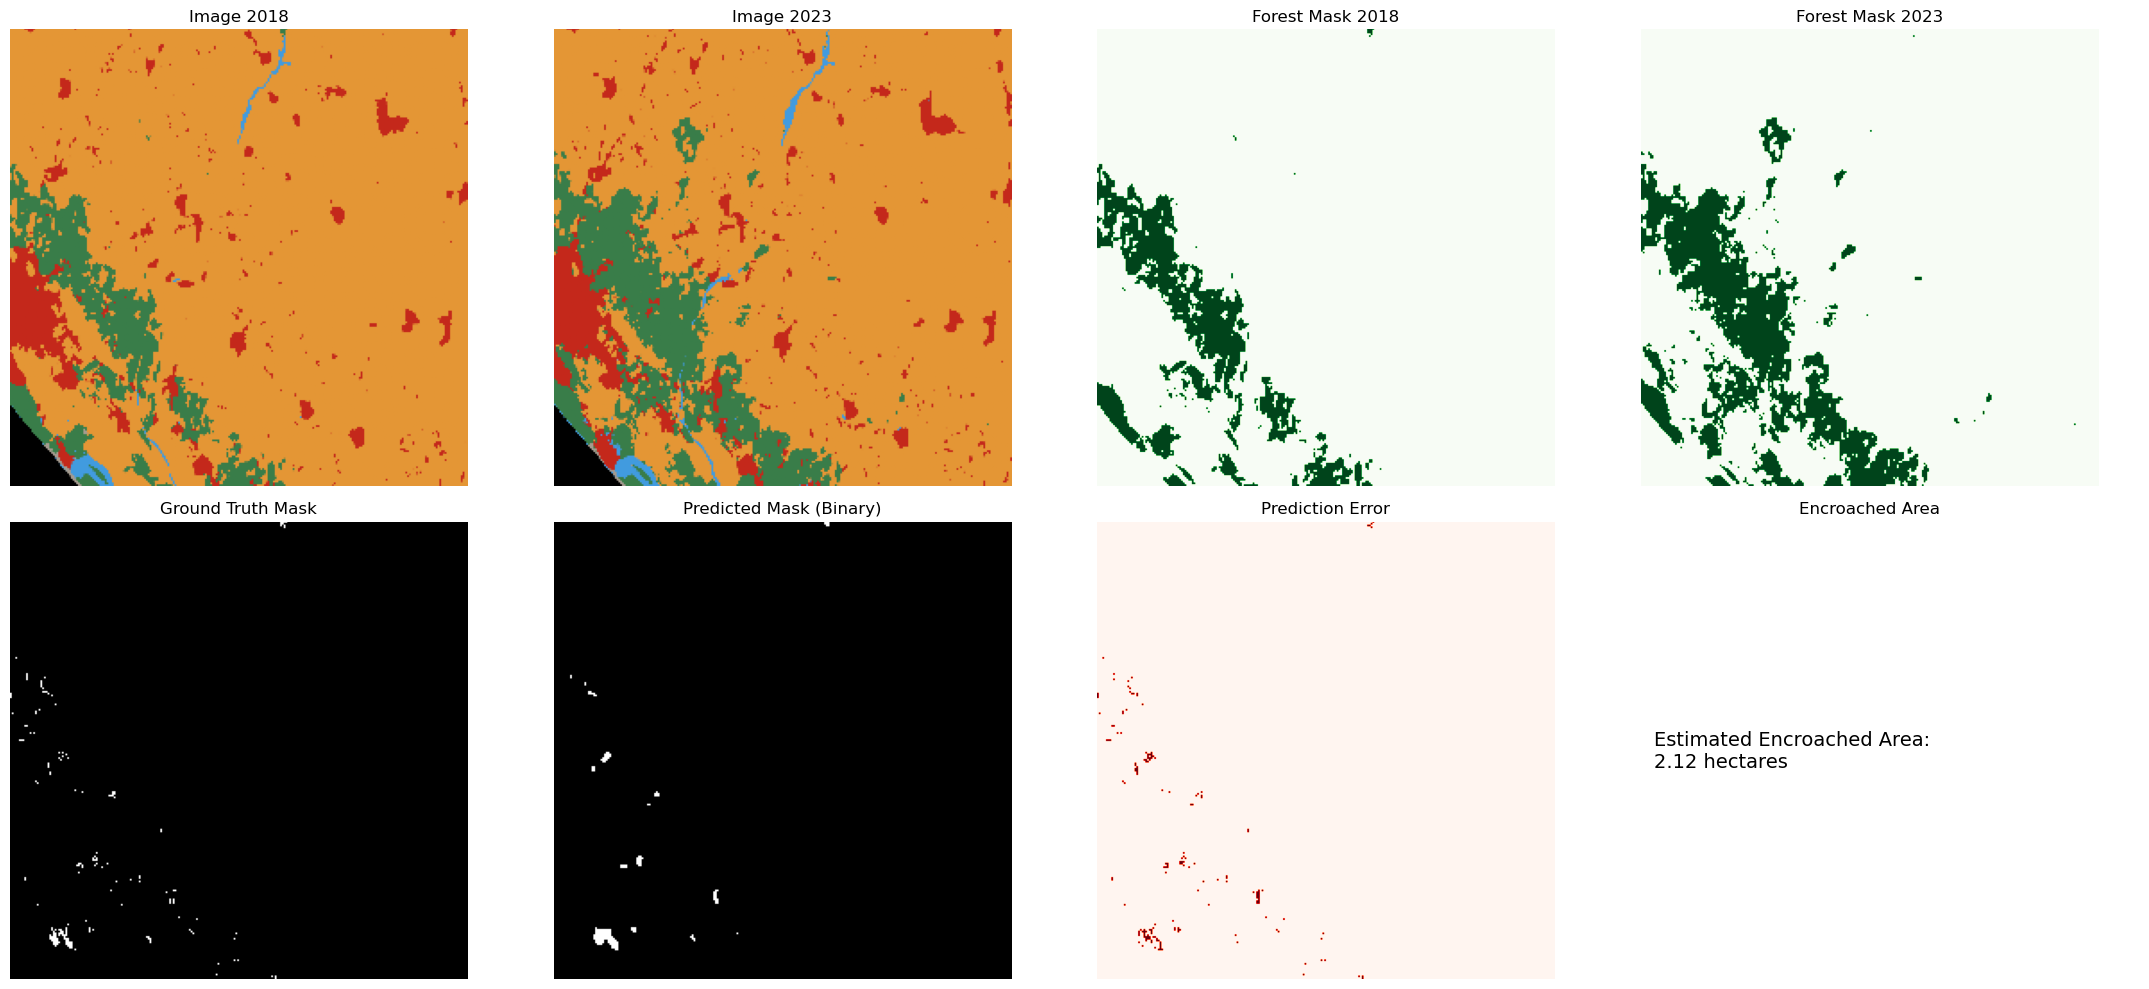

In [7]:
visualize_single_prediction(model, train_gen,pixel_area_m2=100 )
